In [7]:
from mnist import MNIST 
import numpy as np
from pylab import *
from matplotlib import colors
%matplotlib inline

mndata = MNIST('./data')

mndata.load_training()
img_side = 28
n_mnist_pixels = img_side*img_side

In [64]:
labels = mndata.train_labels
# np.where(np.isin(labels,[2]))[0][0]
# np.where(labels == 1)
cluster_size = 10
train_inputs_idx = []
for idx in range(10):
    label_idx = np.where(np.isin(labels,[idx]))[0][:cluster_size]
    train_inputs_idx.append(label_idx)

samples_idx = np.array(train_inputs_idx, dtype='int').flatten()
samples_idx.size

100

W (40, 784) 0.0009999496104443316 3.6093624111610545e-08
RFI 1.0 1.0 1600.0
np.mean(np.array(avg_winner))=1.0
np.mean(np.array(avg_looser))=1.0
31360 2737 10.457800511508951
1.0 1.0 1600.0


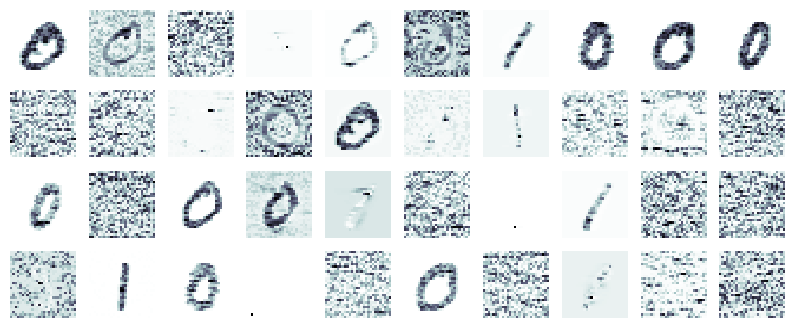

RFI 1.0 0.13127413127413126 1348.7942733826897
np.mean(np.array(avg_winner))=2.15
np.mean(np.array(avg_looser))=2.66
31360 3642 7.610653487095003
1.0 0.0 1044.0
RFI 1.0 0.3877551020408163 1292.7414813596451
np.mean(np.array(avg_winner))=3.57
np.mean(np.array(avg_looser))=3.58
31360 4351 6.207538496897265
1.0 0.0 920.0
RFI 1.0 0.3635204081632653 1246.880418689299
np.mean(np.array(avg_winner))=4.34
np.mean(np.array(avg_looser))=5.07
31360 5524 4.677045619116583
1.0 0.0 812.0
RFI 1.0 0.0 1168.9421870555716
np.mean(np.array(avg_winner))=2.84
np.mean(np.array(avg_looser))=4.85
31360 5208 5.021505376344086
1.0 0.0 824.0
RFI 1.0 0.30994897959183676 1210.0559020342216
np.mean(np.array(avg_winner))=3.22
np.mean(np.array(avg_looser))=5.06
31360 6158 4.092562520298799
1.0 0.0 776.0
RFI 1.0 0.38903061224489793 1165.6398155076554
np.mean(np.array(avg_winner))=4.76
np.mean(np.array(avg_looser))=6.01
31360 6928 3.5265588914549655
1.0 0.0 708.0
RFI 1.0 0.0 1108.4332252111878
np.mean(np.array(avg_winne

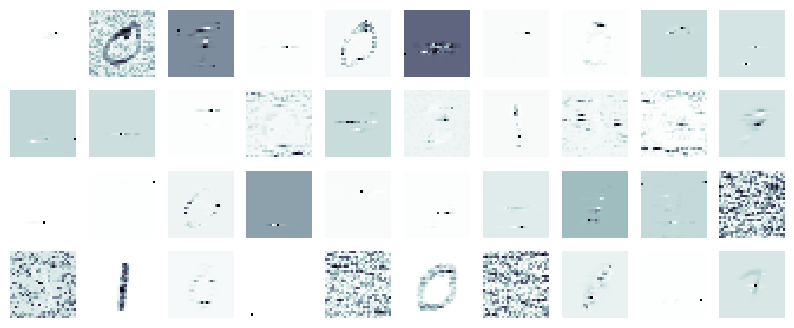

RFI 1.0 0.3163265306122449 1092.764504552807
np.mean(np.array(avg_winner))=2.96
np.mean(np.array(avg_looser))=4.07
31360 9979 2.1425994588636135
1.0 0.0 794.0
RFI 1.0 0.3163265306122449 1102.749559567925
np.mean(np.array(avg_winner))=3.01
np.mean(np.array(avg_looser))=4.69
31360 11297 1.7759582189961938
1.0 0.0 784.0
RFI 1.0 0.006377551020408163 1049.8401474263576
np.mean(np.array(avg_winner))=3.34
np.mean(np.array(avg_looser))=4.05
31360 11207 1.7982510930668332
1.0 0.0 860.0
RFI 1.0 0.30612244897959184 1102.2002893950048
np.mean(np.array(avg_winner))=3.57
np.mean(np.array(avg_looser))=3.97
31360 11566 1.7113954694795088
1.0 0.0 872.0
RFI 1.0 0.4387755102040816 1131.1131661508948
np.mean(np.array(avg_winner))=2.44
np.mean(np.array(avg_looser))=3.18
31360 13361 1.3471297058603398
1.0 0.0 964.0
RFI 1.0 0.01913265306122449 1073.1887506914331
np.mean(np.array(avg_winner))=4.1
np.mean(np.array(avg_looser))=4.77
31360 12595 1.4898769352917824
1.0 0.0 952.0
RFI 1.0 0.4086845466155811 1174.64

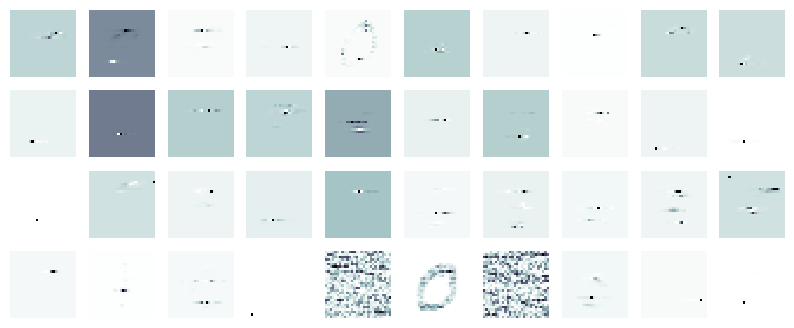

RFI 1.0 0.3687580025608195 1214.6259030653812
np.mean(np.array(avg_winner))=3.46
np.mean(np.array(avg_looser))=4.75
31360 13352 1.3487118034751349
1.0 0.0 1030.0
RFI 1.0 0.38903061224489793 1227.108031855113
np.mean(np.array(avg_winner))=4.02
np.mean(np.array(avg_looser))=5.29
31360 13458 1.3302125130034181
1.0 0.0 996.0
RFI 1.0 0.05612244897959184 1201.5262088959098
np.mean(np.array(avg_winner))=3.57
np.mean(np.array(avg_looser))=4.91
31360 13369 1.3457251851297778
1.0 0.0 1108.0
RFI 1.0 0.3482142857142857 1229.4360435001972
np.mean(np.array(avg_winner))=4.47
np.mean(np.array(avg_looser))=5.97
31360 13408 1.3389021479713603
1.0 0.0 1010.0
RFI 1.0 0.4107142857142857 1258.1742995484146
np.mean(np.array(avg_winner))=3.68
np.mean(np.array(avg_looser))=5.58
31360 13059 1.401408989968604
1.0 0.0 1068.0
RFI 1.0 0.461734693877551 1280.4549055076782
np.mean(np.array(avg_winner))=3.45
np.mean(np.array(avg_looser))=5.41
31360 13675 1.293235831809872
1.0 0.0 1120.0
RFI 1.0 0.011479591836734694 12

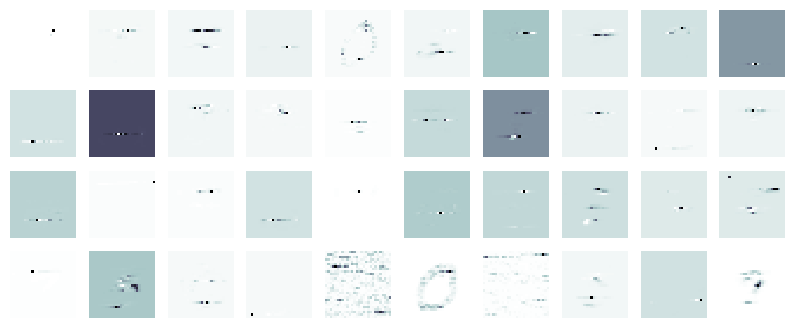

RFI 1.0 0.10204081632653061 1196.3644713460674
np.mean(np.array(avg_winner))=4.21
np.mean(np.array(avg_looser))=4.38
31360 13762 1.2787385554425228
1.0 0.0 1082.0
RFI 1.0 0.029336734693877552 1201.6255631102406
np.mean(np.array(avg_winner))=3.48
np.mean(np.array(avg_looser))=3.57
31360 13509 1.3214153527278112
1.0 0.0 1128.0
RFI 1.0 0.3852040816326531 1258.6500854154506
np.mean(np.array(avg_winner))=4.44
np.mean(np.array(avg_looser))=6.41
31360 13159 1.3831598145755757
1.0 0.0 1032.0
RFI 1.0 0.3903061224489796 1292.6213558697148
np.mean(np.array(avg_winner))=4.39
np.mean(np.array(avg_looser))=6.41
31360 13638 1.2994573984455198
1.0 0.0 1144.0
RFI 1.0 0.3494897959183674 1259.6421907974827
np.mean(np.array(avg_winner))=3.49
np.mean(np.array(avg_looser))=5.03
31360 13460 1.3298662704309063
1.0 0.0 1096.0
RFI 1.0 0.3826530612244898 1285.76763358072
np.mean(np.array(avg_winner))=3.94
np.mean(np.array(avg_looser))=4.33
31360 13554 1.3137081304411982
1.0 0.0 1128.0
RFI 1.0 0.03571428571428571

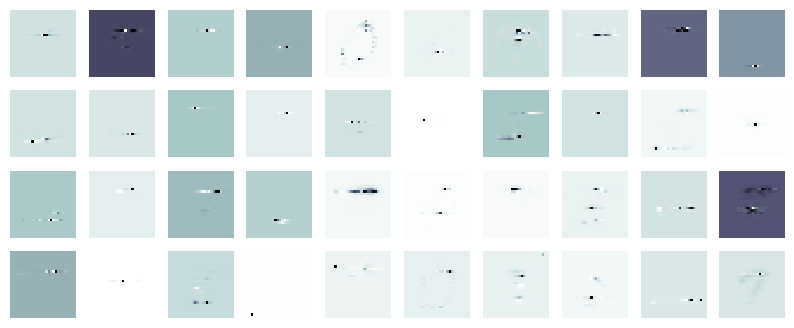

RFI 1.0 0.5392491467576792 1331.297970926118
np.mean(np.array(avg_winner))=4.75
np.mean(np.array(avg_looser))=7.19
31360 14038 1.2339364581849266
1.0 0.0 1000.0
RFI 1.0 0.5676625659050967 1324.400039520087
np.mean(np.array(avg_winner))=6.84
np.mean(np.array(avg_looser))=8.41
31360 14056 1.2310756972111554
1.0 0.0 938.0
RFI 1.0 0.08156028368794327 1309.6110069762906
np.mean(np.array(avg_winner))=3.59
np.mean(np.array(avg_looser))=5.33
31360 14058 1.2307582870963152
1.0 0.0 1240.0
RFI 1.0 0.0549645390070922 1301.2710978745588
np.mean(np.array(avg_winner))=3.87
np.mean(np.array(avg_looser))=5.18
31360 14248 1.2010106681639527
1.0 0.0 1260.0
RFI 1.0 0.2344582593250444 1295.2492934805382
np.mean(np.array(avg_winner))=3.84
np.mean(np.array(avg_looser))=5.13
31360 14023 1.2363260357983312
1.0 0.0 1238.0
RFI 1.0 0.5595026642984015 1333.6934051375551
np.mean(np.array(avg_winner))=6.05
np.mean(np.array(avg_looser))=8.3
31360 13934 1.2506100186593943
1.0 0.0 890.0
RFI 1.0 0.6118881118881119 1354.

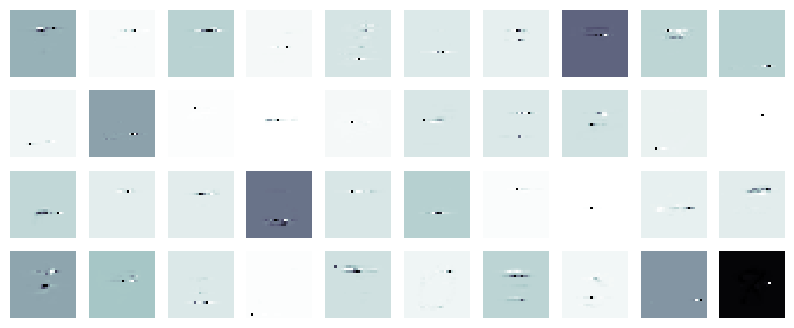

RFI 1.0 0.02486678507992895 1265.4712751912125
np.mean(np.array(avg_winner))=3.31
np.mean(np.array(avg_looser))=5.04
31360 14525 1.1590361445783133
1.0 0.0 1198.0
RFI 1.0 0.05328596802841918 1267.0654061479522
np.mean(np.array(avg_winner))=4.35
np.mean(np.array(avg_looser))=6.17
31360 14443 1.1712940524821713
1.0 0.0 1204.0
RFI 1.0 0.2771929824561403 1287.216131719961
np.mean(np.array(avg_winner))=4.11
np.mean(np.array(avg_looser))=7.09
31360 14321 1.189791215697228
1.0 0.0 1108.0
RFI 1.0 0.2771929824561403 1291.4405858131986
np.mean(np.array(avg_winner))=4.36
np.mean(np.array(avg_looser))=8.06
31360 14244 1.2016287559674248
1.0 0.0 1070.0
RFI 1.0 0.5174216027874564 1310.1112300181971
np.mean(np.array(avg_winner))=4.37
np.mean(np.array(avg_looser))=7.63
31360 14667 1.1381332242449036
1.0 0.0 948.0
RFI 1.0 0.48312611012433393 1270.671662434459
np.mean(np.array(avg_winner))=4.25
np.mean(np.array(avg_looser))=7.57
31360 14460 1.1687413554633472
1.0 0.0 980.0
RFI 1.0 0.3996447602131439 129

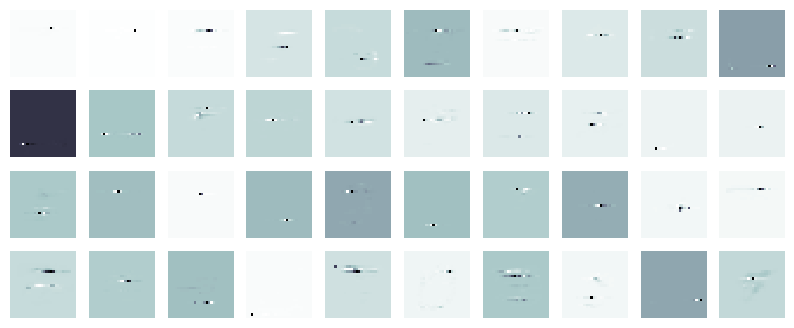

RFI 1.0 0.5625 1325.3283511066718
np.mean(np.array(avg_winner))=5.64
np.mean(np.array(avg_looser))=8.66
31360 13825 1.268354430379747
1.0 0.0 838.0
RFI 1.0 0.566607460035524 1341.336105213703
np.mean(np.array(avg_winner))=4.37
np.mean(np.array(avg_looser))=8.34
31360 14336 1.1875
1.0 0.0 940.0
RFI 1.0 0.014209591474245116 1270.8232374655574
np.mean(np.array(avg_winner))=3.56
np.mean(np.array(avg_looser))=5.42
31360 13971 1.2446496313792856
1.0 0.0 1222.0
RFI 1.0 0.566607460035524 1328.508427644765
np.mean(np.array(avg_winner))=4.27
np.mean(np.array(avg_looser))=5.81
31360 13925 1.252064631956912
1.0 0.0 1016.0
RFI 1.0 0.566607460035524 1337.592378796209
np.mean(np.array(avg_winner))=4.77
np.mean(np.array(avg_looser))=8.1
31360 14007 1.23888055972014
1.0 0.0 912.0
RFI 1.0 0.5316901408450704 1324.8373007666569
np.mean(np.array(avg_winner))=5.17
np.mean(np.array(avg_looser))=6.79
31360 13713 1.2868810617662072
1.0 0.0 912.0
RFI 1.0 0.5772646536412078 1349.3142374442637
np.mean(np.array(av

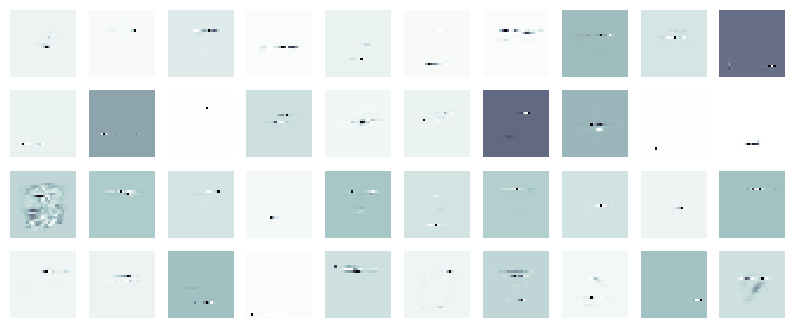

RFI 1.0 0.6141868512110726 1359.9169046429897
np.mean(np.array(avg_winner))=4.17
np.mean(np.array(avg_looser))=7.31
31360 13994 1.2409604116049735
1.0 0.0 882.0
RFI 1.0 0.4798598949211909 1313.9351437502337
np.mean(np.array(avg_winner))=5.22
np.mean(np.array(avg_looser))=8.76
31360 14080 1.2272727272727273
1.0 0.0 968.0
RFI 1.0 0.0053285968028419185 1287.073782682034
np.mean(np.array(avg_winner))=2.72
np.mean(np.array(avg_looser))=3.72
31360 14293 1.194081018680473
1.0 0.0 1268.0
RFI 1.0 0.14209591474245115 1279.5134561542627
np.mean(np.array(avg_winner))=4.11
np.mean(np.array(avg_looser))=5.85
31360 14263 1.1986959265231718
1.0 0.0 1122.0
RFI 1.0 0.25886524822695034 1288.9170656694278
np.mean(np.array(avg_winner))=4.66
np.mean(np.array(avg_looser))=7.05
31360 13737 1.2828856373298392
1.0 0.0 1132.0
RFI 1.0 0.6355785837651122 1356.2941051876142
np.mean(np.array(avg_winner))=5.99
np.mean(np.array(avg_looser))=9.05
31360 14345 1.1861275705820844
1.0 0.0 852.0
RFI 1.0 0.14209591474245115 

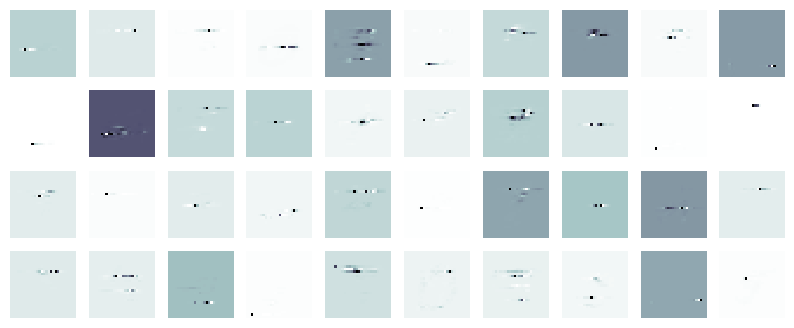

RFI 1.0 0.4493783303730018 1327.1790597740417
np.mean(np.array(avg_winner))=5.0
np.mean(np.array(avg_looser))=7.87
31360 13584 1.3085983510011778
1.0 0.0 1030.0
RFI 1.0 0.6539792387543253 1373.031447386481
np.mean(np.array(avg_winner))=4.86
np.mean(np.array(avg_looser))=8.6
31360 13910 1.254493170381021
1.0 0.0 864.0
RFI 1.0 0.11428571428571428 1325.5064715548392
np.mean(np.array(avg_winner))=4.24
np.mean(np.array(avg_looser))=5.87
31360 13637 1.299626017452519
1.0 0.0 1220.0
RFI 1.0 0.48845470692717585 1365.6279080962508
np.mean(np.array(avg_winner))=4.74
np.mean(np.array(avg_looser))=7.23
31360 13893 1.2572518534513784
1.0 0.0 1010.0
RFI 1.0 0.33035714285714285 1335.9959871258693
np.mean(np.array(avg_winner))=4.91
np.mean(np.array(avg_looser))=7.21
31360 14178 1.2118775567781068
1.0 0.0 1068.0
RFI 1.0 0.05 1304.1740260517377
np.mean(np.array(avg_winner))=3.58
np.mean(np.array(avg_looser))=4.82
31360 14358 1.184148210057111
1.0 0.0 1228.0
RFI 1.0 0.2017857142857143 1275.3068706420454


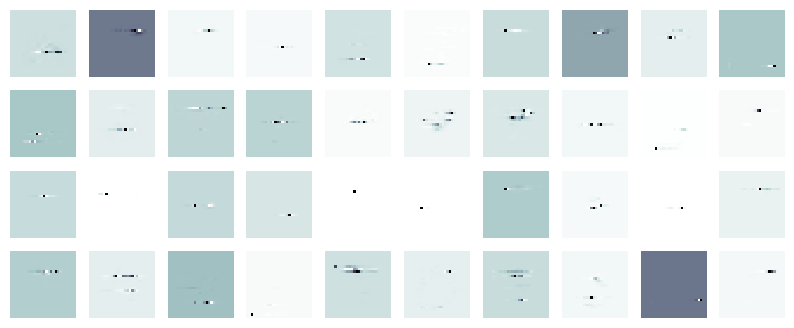

RFI 1.0 0.5097690941385435 1303.6441619493642
np.mean(np.array(avg_winner))=4.38
np.mean(np.array(avg_looser))=5.52
31360 14185 1.2107860415932323
1.0 0.0 994.0
RFI 1.0 0.6143344709897611 1336.7551117857918
np.mean(np.array(avg_winner))=5.15
np.mean(np.array(avg_looser))=8.16
31360 13682 1.2920625639526384
1.0 0.0 924.0
RFI 1.0 0.6547008547008547 1366.7385451530804
np.mean(np.array(avg_winner))=6.0
np.mean(np.array(avg_looser))=9.07
31360 14603 1.1475039375470795
1.0 0.0 894.0
RFI 1.0 0.010676156583629894 1245.8893321789114
np.mean(np.array(avg_winner))=2.53
np.mean(np.array(avg_looser))=3.88
31360 14404 1.1771730074979172
1.0 0.0 1240.0
RFI 1.0 0.1708185053380783 1278.9547535159772
np.mean(np.array(avg_winner))=4.2
np.mean(np.array(avg_looser))=6.14
31360 14034 1.2345731794214052
1.0 0.0 1162.0
RFI 1.0 0.49113475177304966 1323.433839520012
np.mean(np.array(avg_winner))=4.32
np.mean(np.array(avg_looser))=6.05
31360 14243 1.201783332163168
1.0 0.0 988.0
RFI 1.0 0.5207100591715976 1312.8

In [73]:
layer_size = 10*4

I = np.zeros(n_mnist_pixels)
O = np.zeros(layer_size)
W = np.random.rand(O.size, I.size) * 0.001
print('W', W.shape, W.max(), W.min())

push_delta = 0.4
k = 1

syn_n = 2.0
lambda_LNR = 1.0

prec = 1e-30

syn_size = W.shape[1]
W_idx = np.arange(syn_size)
W_len = np.abs(W_idx[np.newaxis].T - W_idx)
W_len = (np.array(W_len, dtype='float') + 1) ** -syn_n

epoch_cnt = 100
# i_idx = 10
eps0 = 0.02

RFI_l = []

# WT = np.expand_dims(W, axis=1)
# WW = np.abs(WT * W)
# RFI = np.sum(WW, axis=2)

# RFI_l.append(RFI)

for epoch_idx in range(epoch_cnt):
    eps = (epoch_cnt - epoch_idx) * eps0

    # receptive fields intersection
    bit_W = np.zeros(W.shape)
    bit_W[W != 0] = 1
    WT = np.expand_dims(bit_W, axis=1)
    WW = WT.astype('int') & bit_W.astype('int')
    com_WW = WT.astype('int') | bit_W.astype('int')
    # WW = np.abs(WT - bit_W)
    # WW = np.abs(WT * bit_W)
    RFI = np.sum(WW, axis=2, dtype='float')
    com_RFI = np.sum(com_WW, axis=2, dtype='float')
    RFI = RFI / com_RFI
    print('RFI', RFI.max(), RFI.min(), RFI.sum())
    # RFI += prec
    # RFI = 1e+0 / RFI

    # bit_RFI = RFI
    bit_RFI = np.zeros(RFI.shape)
    RFI_tr = np.mean(RFI)
    bit_RFI[np.where(RFI < RFI_tr)] = 0
    bit_RFI[np.where(RFI >= RFI_tr)] = 1

    avg_winner = []
    avg_looser = []
    for i_idx in samples_idx:
        img = mndata.train_images[i_idx]

        # infer
        I = np.array(img) / 255
        O = np.dot(W, I)

        # train
        dW = I - (W * O[np.newaxis].T)

        # multy train
        OF = O[np.newaxis].T * bit_RFI
        ArS = np.argsort(OF, axis=0)[::-1][0:1+k]
        winners = np.unique(ArS[0].flatten())
        loosers = np.unique(ArS[1:1+k].flatten())
        # print(f'{winners.size=}')
        # print(f'{loosers.size=}')
        avg_winner.append(winners.size)
        avg_looser.append(loosers.size)

        O.fill(0)
        O[winners] = 1
        O[loosers] += -push_delta
        dW *= O[np.newaxis].T
        dW *= eps

        # local synapse reinforcement
        dLNR = np.dot(W, W_len)
        dLNR = dLNR / np.max(np.abs(dLNR))
        # dLNR -= np.min(dLNR)
        dW *= dLNR * lambda_LNR

        # update
        dW_nc = np.abs(np.max(dW))
        if dW_nc < prec:
            dW_nc = prec
        dW = dW / np.abs(np.max(dW))
        W += dW

        if i_idx % 10 == 0:
            # norm
            nc = np.max(np.abs(W), axis=1)
            nc[nc < prec] = prec
            W = W / nc[np.newaxis].T

    print(f'{np.mean(np.array(avg_winner))=}')
    print(f'{np.mean(np.array(avg_looser))=}')

    # remove weak synapses
    WTr_coef = 1e-5
    WTr = WTr_coef * np.mean(np.abs(W), axis=1)
    W[np.where(np.abs(W) < WTr[np.newaxis].T)] = 0

    RFI_l.append(RFI)

    print(W.size, np.sum(W == 0), np.sum(W != 0) / np.sum(W == 0))
    # print(np.sum(W == 0))
    print(bit_RFI.max(), bit_RFI.min(), bit_RFI.sum())

    if epoch_idx % 10 == 0:
        # W img fig.
        row_size = 10
        col_size = int(layer_size / row_size)

        figure(figsize=(row_size, col_size))

        for col_idx in range(col_size):
            for row_idx in range(row_size):
                n_W_idx = col_idx * row_size + row_idx

                aimg = W[n_W_idx].reshape(img_side, img_side)

                subplot(col_size, row_size, n_W_idx + 1)

                imshow(aimg, interpolation='none', aspect='auto', cmap='bone')
                axis("off")

        show()


In [5]:
for RFI in RFI_l:
    # rfi = 1 / np.exp(np.copy(RFI))
    rfi = np.copy(RFI)
    # rfi = W.shape[1] - rfi
    print(f'{rfi.max()=}')
    print(f'{rfi.min()=}')
    print(f'{np.median(rfi)=}')
    print(f'{np.mean(rfi)=}')
    print(f'{rfi.shape=}')
    print('_')


rfi.max()=0.00028164674931761423
rfi.min()=0.00017882753480961852
np.median(rfi)=0.00019640396690308169
np.mean(rfi)=0.00019783036711511573
rfi.shape=(40, 40)
_
rfi.max()=0.0
rfi.min()=0.0
np.median(rfi)=0.0
np.mean(rfi)=0.0
rfi.shape=(40, 40)
_
rfi.max()=0.0
rfi.min()=0.0
np.median(rfi)=0.0
np.mean(rfi)=0.0
rfi.shape=(40, 40)
_
rfi.max()=740.0
rfi.min()=0.0
np.median(rfi)=740.0
np.mean(rfi)=703.925
rfi.shape=(40, 40)
_
rfi.max()=740.0
rfi.min()=0.0
np.median(rfi)=740.0
np.mean(rfi)=703.925
rfi.shape=(40, 40)
_
rfi.max()=740.0
rfi.min()=0.0
np.median(rfi)=740.0
np.mean(rfi)=703.925
rfi.shape=(40, 40)
_
rfi.max()=505.0
rfi.min()=0.0
np.median(rfi)=505.0
np.mean(rfi)=471.76875
rfi.shape=(40, 40)
_
rfi.max()=314.0
rfi.min()=0.0
np.median(rfi)=314.0
np.mean(rfi)=289.98
rfi.shape=(40, 40)
_
rfi.max()=281.0
rfi.min()=0.0
np.median(rfi)=281.0
np.mean(rfi)=254.53625
rfi.shape=(40, 40)
_
rfi.max()=275.0
rfi.min()=0.0
np.median(rfi)=275.0
np.mean(rfi)=248.875
rfi.shape=(40, 40)
_
rfi.max()=276.0

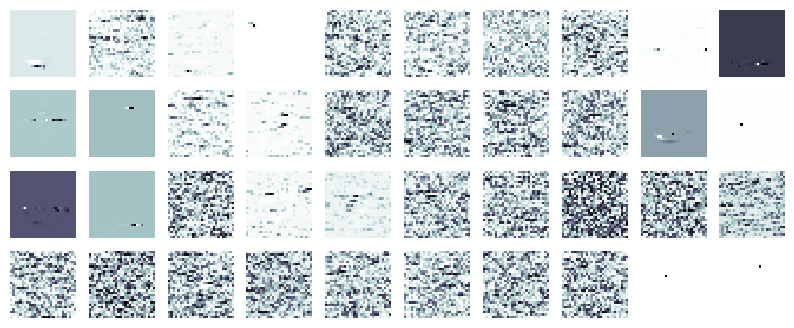

In [6]:
from pylab import *
from matplotlib import colors
%matplotlib inline

row_size = 10
col_size = int(layer_size / row_size)

figure(figsize=(row_size, col_size))

for col_idx in range(col_size):
    for row_idx in range(row_size):
        n_W_idx = col_idx * row_size + row_idx

        aimg = W[n_W_idx].reshape(img_side, img_side)

        subplot(col_size, row_size, n_W_idx + 1)

        imshow(aimg, interpolation='none', aspect='auto', cmap='bone')
        axis("off")

show()


1374
882


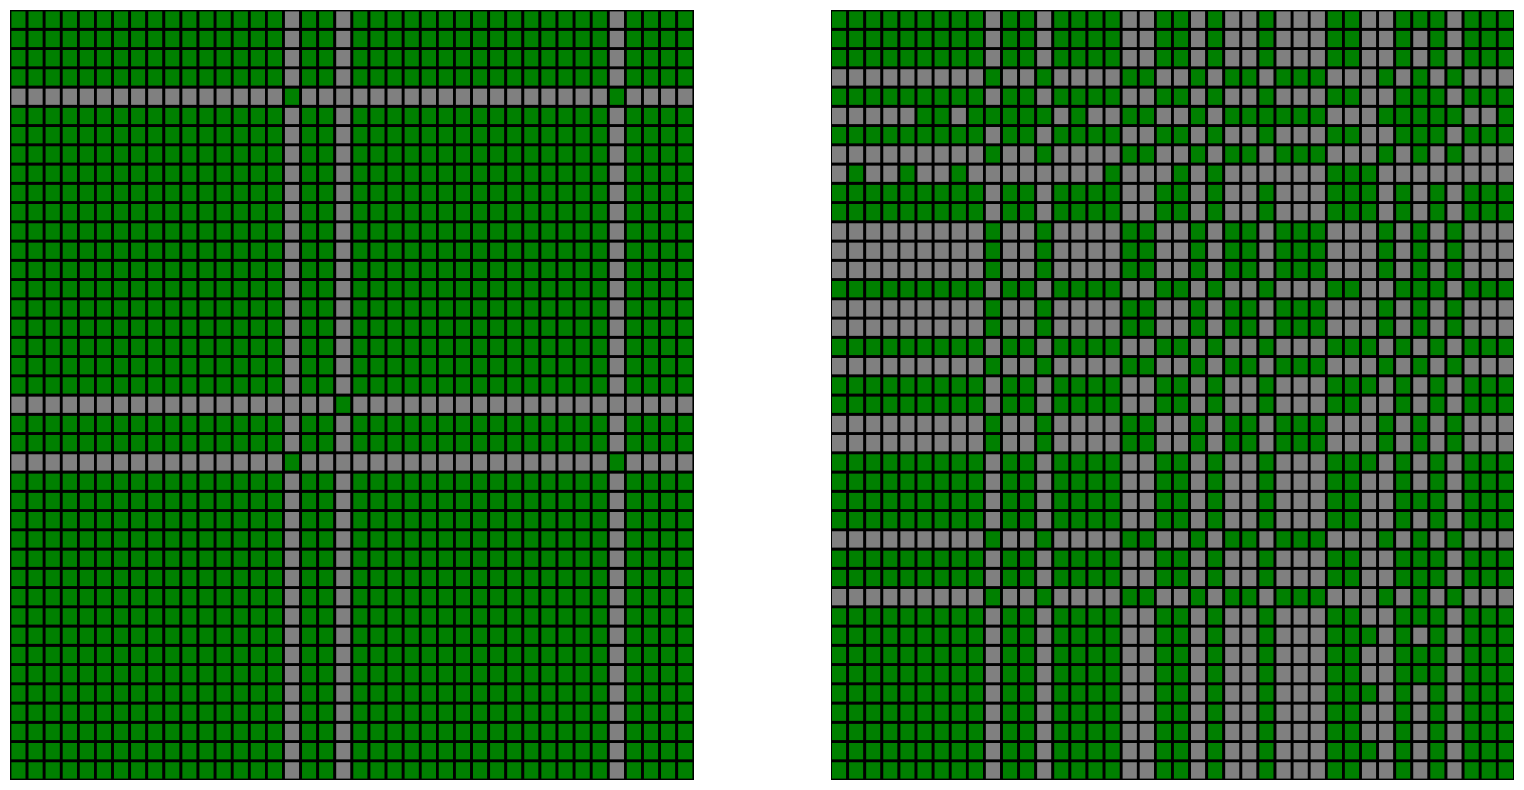

In [6]:
from pylab import *
from matplotlib import colors
%matplotlib inline

# for RFI in RFI_l:
#     print(RFI.max())
#     print(RFI.min())
#     print(np.median(RFI_l))
#     print('_')

size = 10
figure(figsize=(len(RFI_l) * size, 1 * size))
cmap = colors.ListedColormap(['grey', 'green'])

bit_RFI_l = []

for RFI_idx in range(1, len(RFI_l)):
    rfi = np.copy(RFI_l[RFI_idx])
    img = np.zeros(rfi.shape)
    # rfi = np.max(rfi) - rfi

    # tr = 1.0 * np.mean(rfi)
    # print(rfi.min())
    tr = 0.5 * W.shape[1]
    img[np.where(rfi <= tr)] = 0
    img[np.where(rfi > tr)] = 1

    bit_RFI_l.append(img)

    print(np.sum(img == 1))

    subplot(1, len(RFI_l), RFI_idx + 1)

    plt.pcolor(img, cmap=cmap, edgecolors='k', linewidths=2)
    # imshow(rfi, interpolation='none', aspect='auto', cmap='gray')
    axis("off")

show()


In [14]:
for inp_idx in  samples_idx:
    inp_sample = mndata.train_images[inp_idx]

    for RFI_idx in range(len(bit_RFI_l)):
        # infer
        I = np.array(inp_sample) / 255
        O = np.dot(W, I)

        # multy train
        OF = O[np.newaxis].T * bit_RFI_l[RFI_idx]
        # print(f'{O=}')
        # print(f'{OF=}')

        ArS = np.argsort(OF, axis=0)[::-1][0:1+k]
        # print(f'{ArS=}')
        # print(f'{ArS[0]=}')
        # print(f'{np.unique(ArS[0]).size=}')
        # print(f'{np.unique(ArS[1:1+k].flatten()).size=}')

        # O_idx = np.arange(O.size)
        # winner_idx = np.where(O_idx == ArS[0])
        # print(winner_idx)
        # ars = ArS.T[winner_idx].T

        winners = np.unique(ArS[0].flatten())
        loosers = np.unique(ArS[1:1+k].flatten())

        print('win=', winners.size)
        print('loose=', loosers.size)

        # O.fill(0)
        # O[winners] = 1
        # O[loosers] = -push_delta
    
    print('-')


win= 2
loose= 3
win= 3
loose= 5
-
win= 2
loose= 3
win= 3
loose= 6
-
win= 2
loose= 3
win= 2
loose= 5
-
win= 2
loose= 3
win= 2
loose= 4
-
win= 2
loose= 3
win= 4
loose= 6
-
win= 2
loose= 3
win= 3
loose= 6
-
win= 2
loose= 3
win= 4
loose= 4
-
win= 3
loose= 3
win= 3
loose= 4
-
win= 2
loose= 3
win= 3
loose= 5
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 2
loose= 3
win= 3
loose= 5
-
win= 2
loose= 2
win= 3
loose= 4
-
win= 2
loose= 3
win= 3
loose= 4
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 2
loose= 3
win= 3
loose= 5
-
win= 2
loose= 3
win= 3
loose= 4
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 2
loose= 3
win= 3
loose= 5
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 2
loose= 3
win= 1
loose= 3
-
win= 3
loose= 3
win= 2
loose= 5
-
win= 2
loose= 3
win= 3
loose= 5
-
win= 2
loose= 3
win= 3
loose= 5
-
win= 3
loose= 3
win= 2
loose= 4
-
win= 2
loose= 3
win= 3
loose= 4
-
win= 3
loose= 3
win= 2
loose= 4
-
win= 2
loose= 3
win= 4
loose= 5
-
win= 3
loose= 